# 役割
オフライン検証を行うnotebook。事前に`v3_2_0/data/02_features/features.csv`を作成しておく必要がある。
- 学習データ：2018年1月〜2022年9月
- 検証データ（Early stopping・Calibration補正）：2022年10月〜2022年12月
    - Early stoppingについては[#14の記事](https://note.com/dijzpeb/n/n67ef63cf345f)、Calibration補正については[#22の記事](https://note.com/dijzpeb/n/nef0d54028813)で解説
- テストデータ：2023年1月〜2023年12月

# インポート

In [1]:
from training import Dataset, Trainer
from evaluationing import plot_calibration, Evaluator
%load_ext autoreload

In [12]:
# モジュールを更新した場合、以下を実行することで更新を反映させる
%autoreload

# 学習

In [2]:
# データセット作成
dataset = Dataset(
    train_start_date="2018-01-01",
    valid_start_date="2022-10-01",
    valid_end_date="2022-12-31",
    test_start_date="2023-01-01",
    test_end_date="2023-12-31",
    target_strategy=0,  # 1着と0.0秒差も1着として扱う
)

In [7]:
# 学習実行
trainer = Trainer(config_filepath="config.yaml")
evaluation_df = trainer.run(
    dataset=dataset,
    importance_filename="importance",
    model_filename="model.pkl",
    calibration_model_filename="calibration_model.pkl",
    evaluation_filename="evaluation.csv",
)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.214244
[200]	valid_0's binary_logloss: 0.205962
[300]	valid_0's binary_logloss: 0.203812
[400]	valid_0's binary_logloss: 0.203178
[500]	valid_0's binary_logloss: 0.202822
[600]	valid_0's binary_logloss: 0.202702
[700]	valid_0's binary_logloss: 0.202669
[800]	valid_0's binary_logloss: 0.202597
[900]	valid_0's binary_logloss: 0.20257
[1000]	valid_0's binary_logloss: 0.202502
[1100]	valid_0's binary_logloss: 0.202529
Early stopping, best iteration is:
[1008]	valid_0's binary_logloss: 0.202484
-------------------- result --------------------
test_df's binary_logloss: 0.20528544428144413


In [ ]:
# オッズと人気を特徴量から省いた場合
trainer = Trainer(config_filepath="config_odds_removed.yaml")
_ = trainer.run(
    dataset=dataset,
    importance_filename="importance_odds_removed",
    model_filename="model_odds_removed.pkl",
    calibration_model_filename="calibration_model_odds_removed.pkl",
    evaluation_filename="evaluation_odds_removed.csv",
)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.243355
[200]	valid_0's binary_logloss: 0.236492
[300]	valid_0's binary_logloss: 0.234034
[400]	valid_0's binary_logloss: 0.232847
[500]	valid_0's binary_logloss: 0.232171
[600]	valid_0's binary_logloss: 0.231701
[700]	valid_0's binary_logloss: 0.231431
[800]	valid_0's binary_logloss: 0.231237
[900]	valid_0's binary_logloss: 0.231118
[1000]	valid_0's binary_logloss: 0.230901
[1100]	valid_0's binary_logloss: 0.230859
[1200]	valid_0's binary_logloss: 0.230752
[1300]	valid_0's binary_logloss: 0.230707
[1400]	valid_0's binary_logloss: 0.230626
[1500]	valid_0's binary_logloss: 0.230545
[1600]	valid_0's binary_logloss: 0.230473
[1700]	valid_0's binary_logloss: 0.230386
[1800]	valid_0's binary_logloss: 0.230408
Early stopping, best iteration is:
[1742]	valid_0's binary_logloss: 0.230375
-------------------- result --------------------
test_df's binary_logloss: 0.22044545465779256


# 精度評価

In [8]:
evaluator = Evaluator()

## キャリブレーション

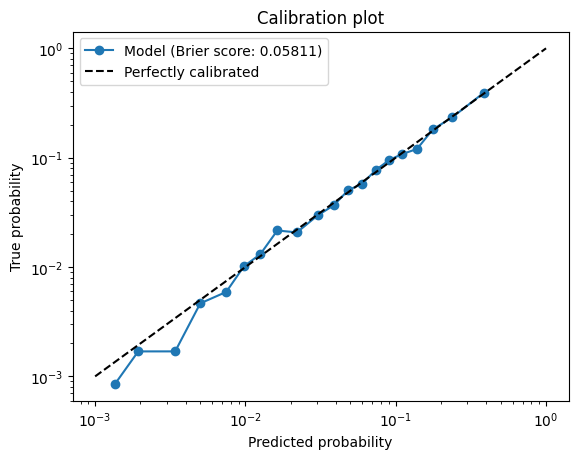

In [9]:
# 補正前
evaluator.plot_calibration()

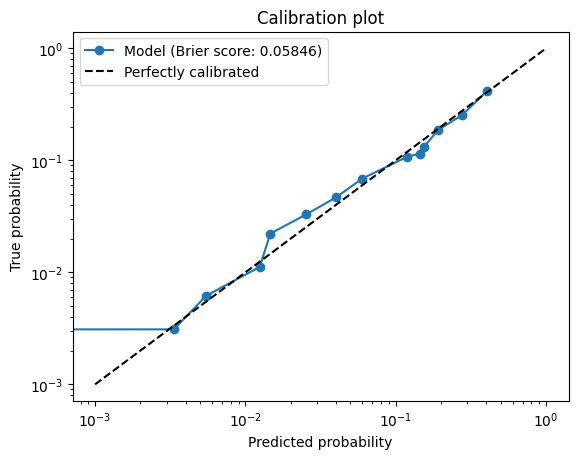

In [10]:
# 補正後
evaluator.plot_calibration(pred_col="pred_calibrated")

## 回収率・シャープレシオ

best result:
{'expect_return': 1.4181818181818182,
 'n_hits': 15.0,
 'return_rate': 1.4126811594202897,
 'sharp_ratio': 0.8339312760470317,
 'std': 0.4948623121277628,
 'total_bet': 276.0,
 'total_payoff': 389.9}


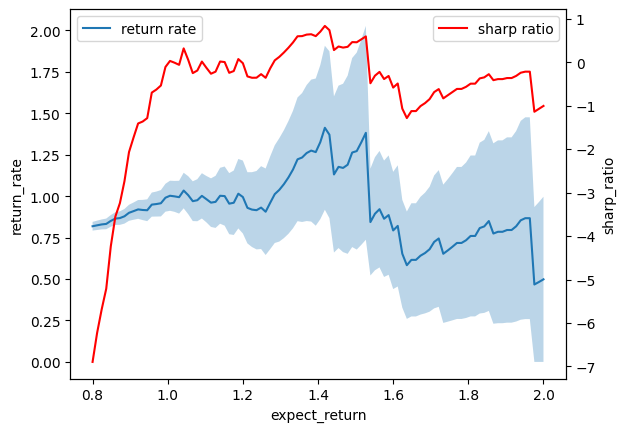

In [13]:
result_df = evaluator.bet_by_expect_return(
    min_exp=0.8, max_exp=2.0, min_pred=0.01, pred_col="pred"
)

In [14]:
result_df.sort_values("sharp_ratio", ascending=False).head()

,expect_return,total_bet,total_payoff,return_rate,std,n_hits,sharp_ratio
51,1.418182,276,389.9,1.412681,0.494862,15,0.833931
52,1.430303,268,367.4,1.370896,0.503386,14,0.736801
50,1.406061,294,389.9,1.326190,0.464942,15,0.701573
48,1.381818,321,409.3,1.275078,0.428199,17,0.642407
47,1.369697,337,424.7,1.260237,0.410227,18,0.634375


best result:
{'expect_return': 1.4666666666666668,
 'n_hits': 21.0,
 'return_rate': 1.0253776435045316,
 'sharp_ratio': 0.06400817876284867,
 'std': 0.39647501295976906,
 'total_bet': 331.0,
 'total_payoff': 339.4}


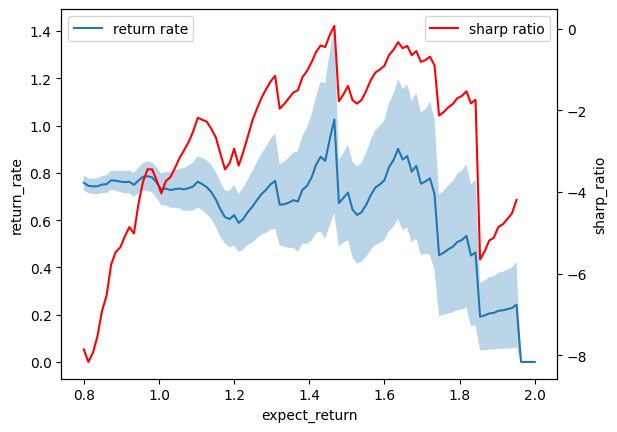

In [15]:
result_df = evaluator.bet_by_expect_return(
    min_exp=0.8, max_exp=2.0, min_pred=0.01, pred_col="pred_calibrated"
)

In [16]:
result_df.sort_values("sharp_ratio", ascending=False).head()

,expect_return,total_bet,total_payoff,return_rate,std,n_hits,sharp_ratio
55,1.466667,331,339.4,1.025378,0.396475,21,0.064008
54,1.454545,360,339.4,0.942778,0.364825,21,-0.156849
69,1.636364,180,162.3,0.901667,0.296213,11,-0.331969
52,1.430303,424,368.3,0.868632,0.317159,22,-0.414203
71,1.660606,171,149.0,0.871345,0.303001,10,-0.424603


## オッズと人気を特徴量から省いたモデル

In [17]:
evaluator_odds_removed = Evaluator(evaluation_filename="evaluation_odds_removed.csv")

FileNotFoundError: [Errno 2] No such file or directory: '..\\data\\03_train\\evaluation_odds_removed.csv'

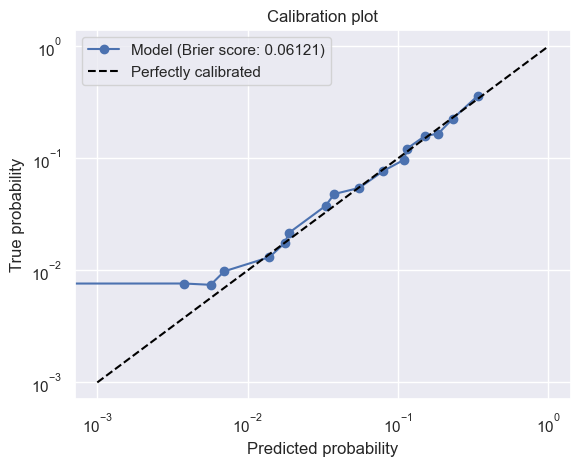

In [ ]:
evaluator_odds_removed.plot_calibration(pred_col="pred_calibrated")